In [37]:
# Standard imports
import os
import cv2
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

Data Processing

In [38]:
df = pd.read_csv('nba.csv')

df = df.dropna() # drop NAs

# data cleaning
df = df.iloc[:, 3:-6] 
df = df.drop(df.columns[[2, 3, 4]], axis=1)

df = df.div(df['G'], axis=0).drop(columns=['G']) # making the season total stats per game stats
df['W'] = df['W'] * 100

df.head()

,W,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,43.902439,43.036585,92.487805,29.317073,54.780488,13.719512,37.707317,18.536585,23.243902,12.487805,32.182927,44.670732,26.585366,7.500000,4.500000,13.536585,18.560976,118.329268
1,78.048780,43.914634,90.195122,27.439024,47.731707,16.475610,42.463415,16.268293,20.170732,10.682927,35.646341,46.329268,26.914634,6.792683,6.560976,11.939024,16.170732,120.573171
2,25.609756,40.012195,86.987805,27.951220,52.987805,12.060976,34.000000,14.500000,18.439024,9.329268,30.951220,40.280488,24.792683,6.853659,4.524390,13.768293,17.951220,106.585366
3,47.560976,42.048780,89.500000,30.573171,57.426829,11.475610,32.073171,16.695122,21.109756,11.170732,32.646341,43.817073,24.975610,7.780488,4.804878,12.243902,18.792683,112.268293
4,58.536585,41.768293,87.170732,28.256098,50.390244,13.512195,36.780488,15.585366,20.378049,9.841463,33.439024,43.280488,28.036585,7.378049,4.634146,13.560976,17.512195,112.634146


In [39]:
# the per game stats
X = df.iloc[:, 1:]
X.shape

(1023, 17)

In [40]:
# win percent in a season
y = df.iloc[:, 0]
y.shape

(1023,)

In [41]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_new.shape)
print(y_train.shape, y_new.shape)

(818, 17) (205, 17)
(818,) (205,)


In [42]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [43]:
# Center the data for PCA
mu = np.mean(X_train,axis = 0, keepdims = True)
X_train_tilde = X_train - mu
X_train_tilde.shape

(818, 17)

In [44]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

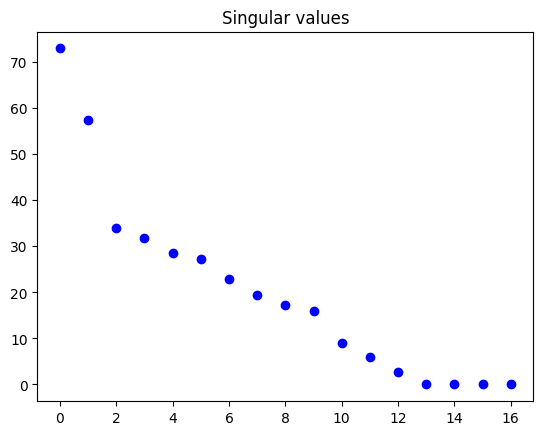

In [45]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

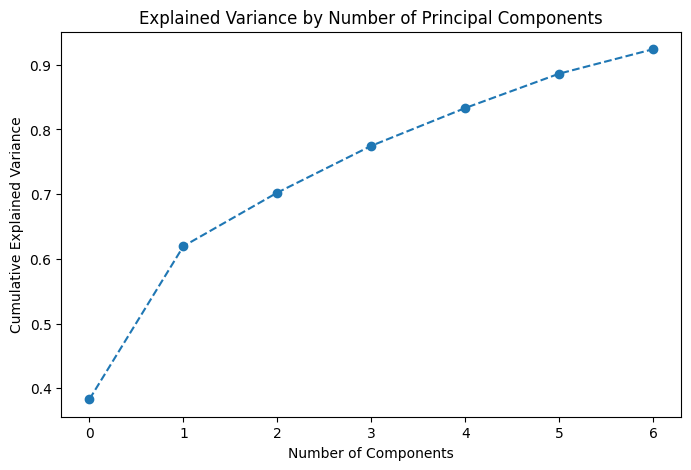

In [46]:
# PCA
pca = PCA(n_components=7)  # Using the 6 highest singular values
X_train_tilde_pca = pca.fit_transform(X_train_tilde)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.show()

In [47]:
# Transform the new data using the same steps
X_new = scaler.transform(X_new)  # Normalize
X_new_tilde = X_new - mu  # Center
X_new_tilde_pca = pca.transform(X_new_tilde)  # Apply PCA

Model Performance Comparison:
                      Model         MSE  R-squared
0         Linear Regression  165.899785   0.288785
1          Ridge Regression  165.882537   0.288859
2          Lasso Regression  168.171303   0.279047
3  Decision Tree Regression  328.700590  -0.409145
4               Elastic Net  173.090705   0.257957


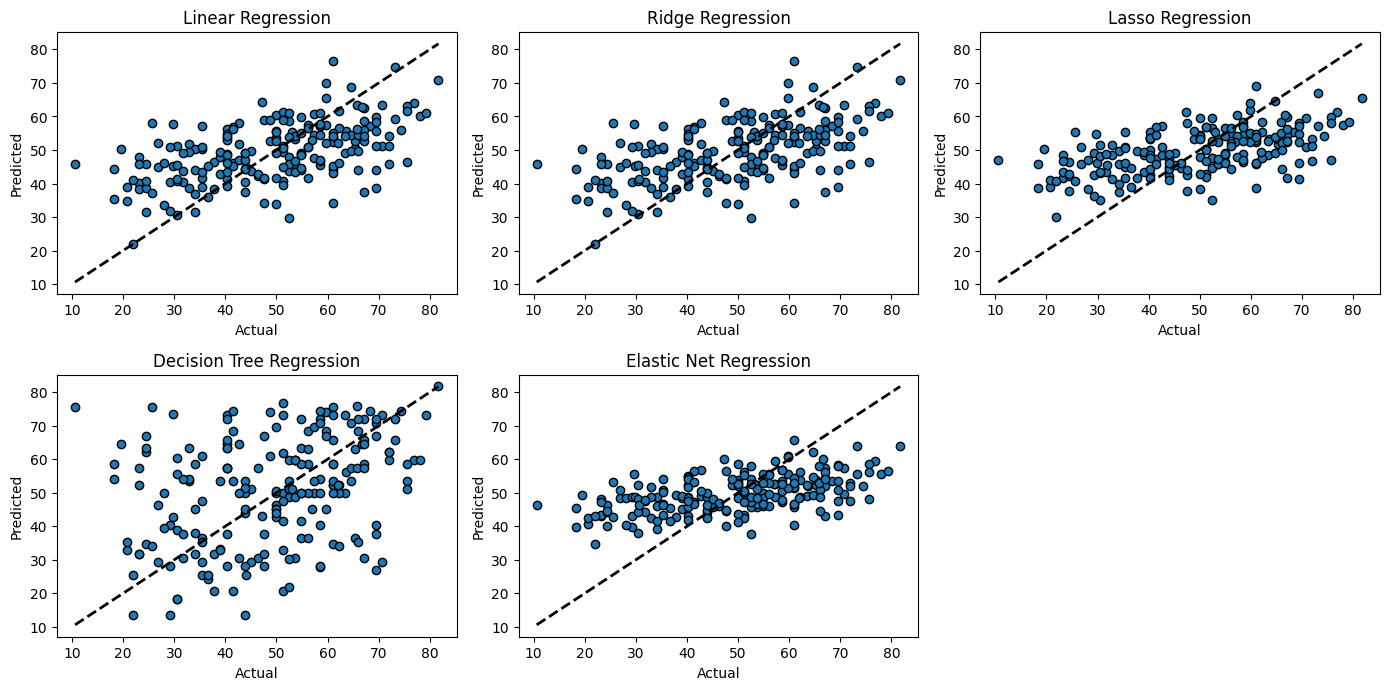

In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_tilde_pca, y_train)
y_pred_lr = lr.predict(X_new_tilde_pca)
mse_lr = mean_squared_error(y_new, y_pred_lr)
r2_lr = r2_score(y_new, y_pred_lr)

# Ridge Regression
ridge = Ridge()
ridge.fit(X_train_tilde_pca, y_train)
y_pred_ridge = ridge.predict(X_new_tilde_pca)
mse_ridge = mean_squared_error(y_new, y_pred_ridge)
r2_ridge = r2_score(y_new, y_pred_ridge)

# Lasso Regression
lasso = Lasso()
lasso.fit(X_train_tilde_pca, y_train)
y_pred_lasso = lasso.predict(X_new_tilde_pca)
mse_lasso = mean_squared_error(y_new, y_pred_lasso)
r2_lasso = r2_score(y_new, y_pred_lasso)

# Decision Tree Regression
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_tilde_pca, y_train)
y_pred_dt = dt.predict(X_new_tilde_pca)
mse_dt = mean_squared_error(y_new, y_pred_dt)
r2_dt = r2_score(y_new, y_pred_dt)

# Decision Tree Regression
en = ElasticNet(random_state=42)
en.fit(X_train_tilde_pca, y_train)
y_pred_en = en.predict(X_new_tilde_pca)
mse_en = mean_squared_error(y_new, y_pred_en)
r2_en = r2_score(y_new, y_pred_en)

# Display results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree Regression', 'Elastic Net'],
    'MSE': [mse_lr, mse_ridge, mse_lasso, mse_dt, mse_en],
    'R-squared': [r2_lr, r2_ridge, r2_lasso, r2_dt, r2_en]
})

print("Model Performance Comparison:")
print(results)

# Plotting actual vs predicted values for each model
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(3, 3, 1)
plt.scatter(y_new, y_pred_lr, edgecolors=(0, 0, 0))
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression')

# Ridge Regression
plt.subplot(3, 3, 2)
plt.scatter(y_new, y_pred_ridge, edgecolors=(0, 0, 0))
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Ridge Regression')

# Lasso Regression
plt.subplot(3, 3, 3)
plt.scatter(y_new, y_pred_lasso, edgecolors=(0, 0, 0))
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Lasso Regression')

# Decision Tree Regression
plt.subplot(3, 3, 4)
plt.scatter(y_new, y_pred_dt, edgecolors=(0, 0, 0))
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree Regression')

# Elastic Net Regression
plt.subplot(3, 3, 5)
plt.scatter(y_new, y_pred_en, edgecolors=(0, 0, 0))
plt.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Elastic Net Regression')

plt.tight_layout()
plt.show()
